In [1]:
import tensorflow as tf


# maintain consistent performance
tf.random.set_seed(1)  # define a semente para garantir reprodutibilidade

# confirm GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # verifica quantas gpus estao disponiveis


Num GPUs Available:  0


In [2]:
from tensorflow.keras.datasets import fashion_mnist

# load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
import numpy as np

# merge the training and testing sets
dataset = np.concatenate([x_train, x_test], axis=0)  # combina os conjuntos de treino e teste pois nao tem nenhuma utilizade o conjunto teste

# normalize the images from [0,255] to [0,1]
dataset = np.expand_dims(dataset, -1).astype("float32") / 255  # normaliza as imagens para o intervalo [0,1], o que a funcao sigmoid espera


In [4]:
BATCH_SIZE = 64 #tamanho do lote

# convolution layers work 3 channels
dataset = np.reshape(dataset, (-1, 28, 28, 1))  # reorganiza as imagens para a forma esperada pela rede convolucional

# create a tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices(dataset)  # cria um objeto Dataset do TensorFlow a partir dos dados

# set the batch size otherwise it reads one image at a time
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)  # embaralha os dados e define o tamanho do lote


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

# hiperparametro do tamanho do vetor de ruido
NOISE_DIM = 150

# define o gerador da GAN
generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(NOISE_DIM,)),  # camada de entrada com o vetor de ruido
    layers.Dense(7 * 7 * 256),  # camada densa para gerar um vetor com tamanho adequado
    layers.Reshape(target_shape=(7, 7, 256)),  # reorganiza o vetor para a forma (7, 7, 256)
    layers.Conv2DTranspose(256, 3, strides=2, padding="same"),  # camada convolucional transposta
    layers.LeakyReLU(alpha=0.2),  # LeakyReLU como camada separada
    layers.Conv2DTranspose(128, 3, strides=2, padding="same"),  # outra camada convolucional transposta
    layers.LeakyReLU(alpha=0.2),  # outra camada de LeakyReLU
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")  # ultima camada gera a imagem final
])

generator.summary()  # exibe o resumo do modelo gerador


C:\Users\Higor\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\Higor\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,894,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,780,417 (10.61 MB)

 Trainable params: 2,780,417 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#faremos o descriminador (muito parecido com o vae, tanto a parte anterior, quanto essa)

# design a discriminator with downsampling layers
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),  # camada de entrada com a imagem de tamanho 28x28 na cor cinza
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),  # camada convolucional para reduzir a resolução
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),  # outra camada convolucional
  layers.Flatten(),  # achata a saída das camadas convolucionais para vetor
  layers.Dense(64, activation="relu"),  # camada densa
  layers.Dropout(0.2),  # dropout para regularização
  layers.Dense(1, activation="sigmoid")  # camada final para prever se a imagem é real ou falsa
])

discriminator.summary()  # exibe o resumo do modelo discriminador


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,137 (2.67 MB)

 Trainable params: 699,137 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#Responsavel pela loos function, semelhante aos VAEs

# set different learning rates for the generator and the discriminator
# we want to maintain the game balance until we arrive at the nash-equilibria
# if the discriminator gets very strong or very weak the adversarial game fails
# higher learning rates impact the stability of the adversarial game severely
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)  # otimização para o gerador com taxa de aprendizagem baixa
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)  # otimização para o discriminador com taxa de aprendizagem um pouco maior

# binary classifier (real or fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)  # função de perda para classificação binária

# accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()  # métrica de acurácia para o gerador
dAccMetric = tf.keras.metrics.BinaryAccuracy()  # métrica de acurácia para o discriminador


In [8]:
# treina o discriminador, calculando a perda com base nas imagens reais e falsas,
#aplicando os gradientes para atualizar os pesos e retornando a perda e a acuracia do mesmo

@tf.function
def trainDStep(data):
    batchSize = tf.shape(data)[0]  # obtém o tamanho do lote de dados
    noise = tf.random.normal(shape=(batchSize, NOISE_DIM))  # gera ruído aleatório para o gerador
    
    y_true = tf.concat([
        tf.ones((batchSize, 1)),  # rótulos reais
        tf.zeros((batchSize, 1))  # rótulos falsos
    ], axis=0)
    
    with tf.GradientTape() as tape:
        fake = generator(noise)  # gera imagens falsas usando o gerador
        x = tf.concat([data, fake], axis=0)  # junta as imagens reais e falsas
        y_pred = discriminator(x)  # o discriminador faz a previsão sobre as imagens
        discriminatorLoss = lossFn(y_true, y_pred)  # calcula a perda do discriminador
    
    grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)  # calcula os gradientes
    optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))  # aplica os gradientes para atualizar os pesos
    dAccMetric.update_state(y_true, y_pred)  # atualiza a métrica de acurácia do discriminador
    
    return {"discriminator_loss": discriminatorLoss, "discriminator_accuracy": dAccMetric.result()}  # retorna a perda e a acuráci


In [9]:
# treina o gerador, calculando a perda com base na avaliação do discriminador, 
#aplicando os gradientes para atualizar os pesos do gerador e retornando a perda e a acurácia do mesmo

@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  # when training the generator, we want it to maximize the probability that its
  # output is classified as real, remember the min-max game
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  gAccMetric.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

In [10]:
from matplotlib import pyplot as plt


def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show();

C:\Users\Higor\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


E:0, Loss G:2.9137, Loss D:0.1204, Acc G:%1.00, Acc D:%97.93


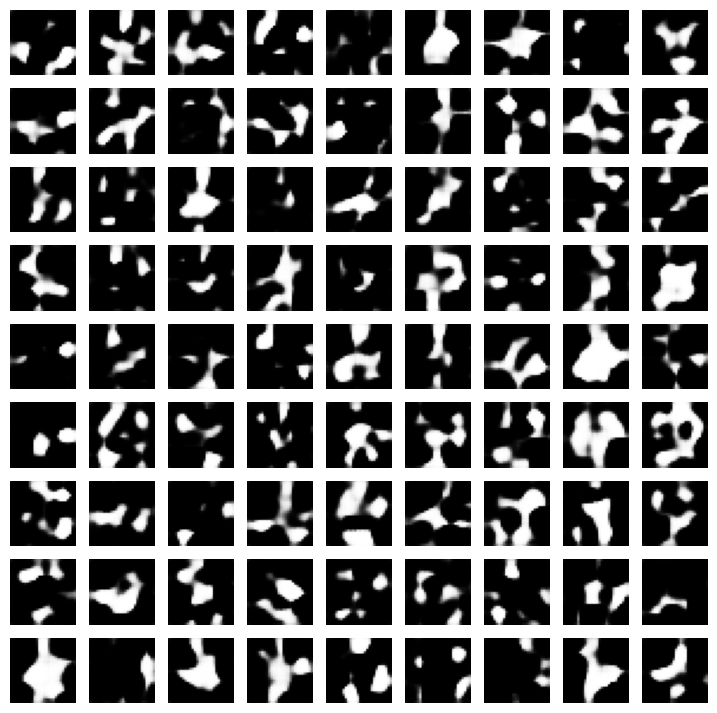

E:1, Loss G:2.9670, Loss D:0.1136, Acc G:%0.79, Acc D:%97.86
E:2, Loss G:3.5520, Loss D:0.0798, Acc G:%0.83, Acc D:%97.75
E:3, Loss G:3.3525, Loss D:0.1209, Acc G:%0.85, Acc D:%97.74
E:4, Loss G:2.2181, Loss D:0.2645, Acc G:%1.49, Acc D:%96.73
E:5, Loss G:1.9801, Loss D:0.3048, Acc G:%2.14, Acc D:%95.45


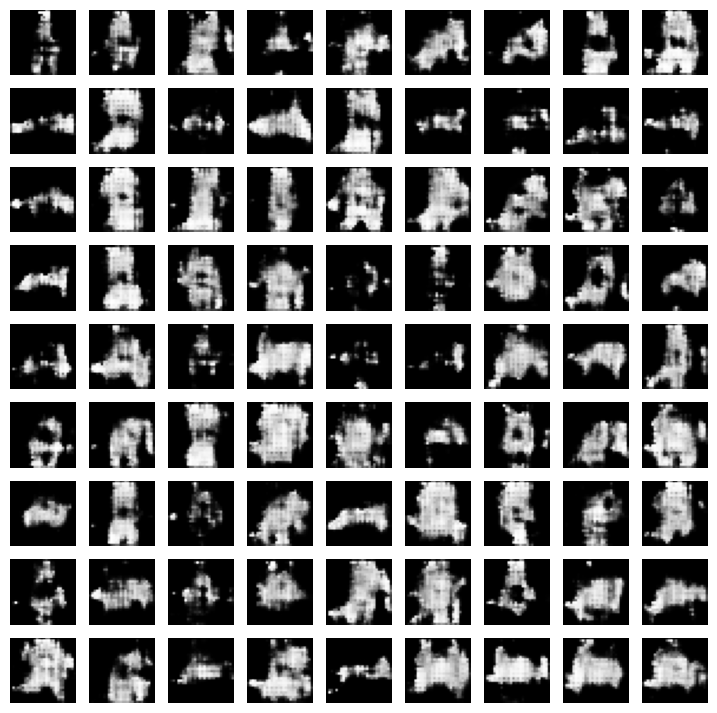

E:6, Loss G:1.8072, Loss D:0.3323, Acc G:%3.09, Acc D:%94.09
E:7, Loss G:1.7513, Loss D:0.3443, Acc G:%3.70, Acc D:%93.23
E:8, Loss G:1.5525, Loss D:0.4033, Acc G:%4.51, Acc D:%92.22
E:9, Loss G:1.5066, Loss D:0.4023, Acc G:%5.38, Acc D:%91.23
E:10, Loss G:1.5343, Loss D:0.3861, Acc G:%5.98, Acc D:%90.52


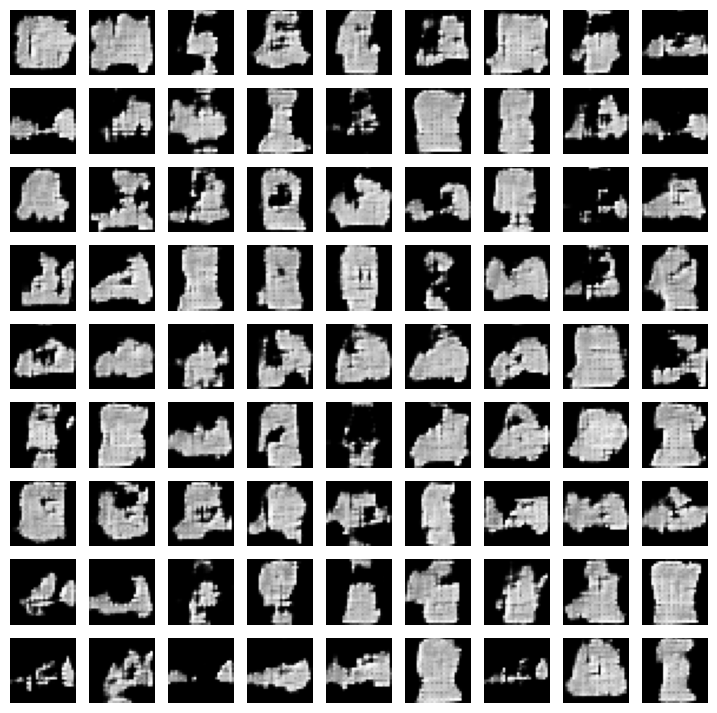

E:11, Loss G:1.5721, Loss D:0.3730, Acc G:%6.40, Acc D:%90.02
E:12, Loss G:1.5987, Loss D:0.3629, Acc G:%6.74, Acc D:%89.62
E:13, Loss G:1.5909, Loss D:0.3790, Acc G:%6.97, Acc D:%89.32
E:14, Loss G:1.5554, Loss D:0.4131, Acc G:%7.31, Acc D:%88.90
E:15, Loss G:1.5206, Loss D:0.4253, Acc G:%7.74, Acc D:%88.43


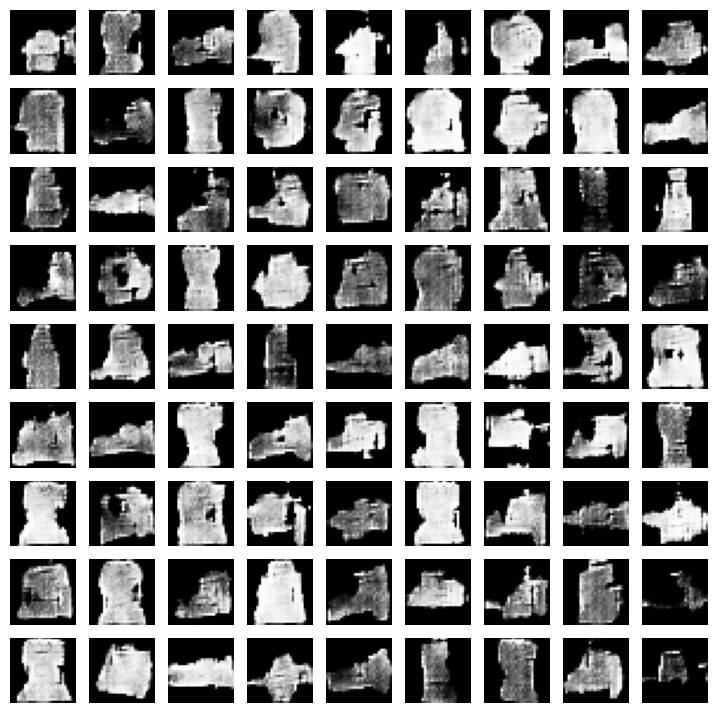

E:16, Loss G:1.5099, Loss D:0.4181, Acc G:%8.12, Acc D:%88.01
E:17, Loss G:1.5447, Loss D:0.4018, Acc G:%8.38, Acc D:%87.70
E:18, Loss G:1.5568, Loss D:0.3977, Acc G:%8.58, Acc D:%87.46
E:19, Loss G:1.5551, Loss D:0.3935, Acc G:%8.75, Acc D:%87.24


In [11]:
#por algum motivo, esta etapa esta consumindo a gpu, onde esta ficando inviavel eu rodar o codigo com varias epocas, 
#correto conforme o video

for epoch in range(20):  # Loop principal de treinamento por 30 épocas

  dLossSum = 0  # acumula a perda do discriminador
  gLossSum = 0  # acumula a perda do gerador
  dAccSum = 0   # acumula a acurácia do discriminador
  gAccSum = 0   # acumula a acurácia do gerador
  cnt = 0       # contador de lotes

  for batch in dataset:  # percorre o dataset lote por lote
    
    dLoss = trainDStep(batch)  # treina o discriminador
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    gLoss = trainGStep(batch)  # treina o gerador
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    cnt += 1  # incrementa o contador de lotes

  # exibe o desempenho do modelo a cada época
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))
    
  if epoch % 5 == 0:  # a cada 5 epocas, gera e exibe imagens
    plotImages(generator)

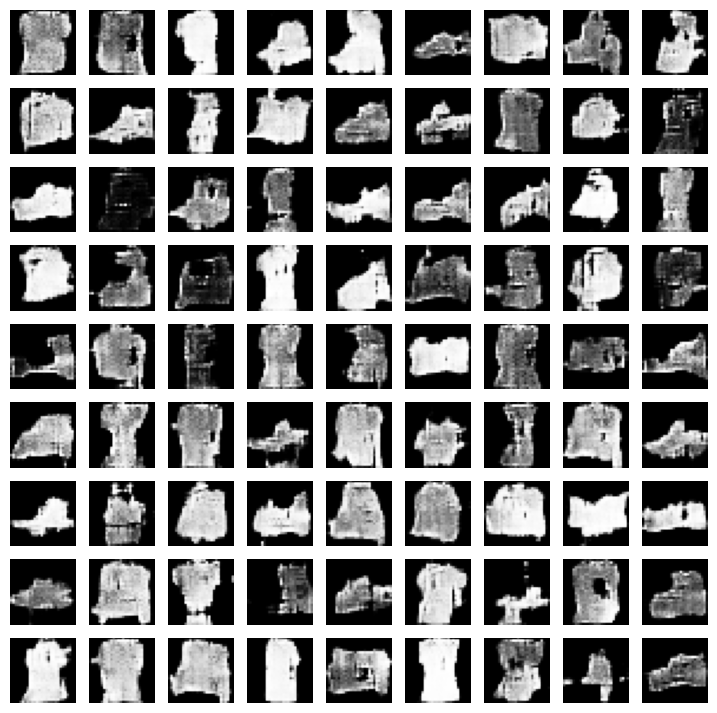

In [12]:

images = generator(np.random.normal(size=(81, NOISE_DIM)))  # fera 81 imagens com o gerador treinado

from matplotlib import pyplot as plt  # importa biblioteca para plotagem

plt.figure(figsize=(9, 9))  # define o tamanho da figura

for i, image in enumerate(images):  # itera sobre as imagens geradas
    plt.subplot(9,9,i+1)  # organiza as imagens em uma grade 9x9
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")  # exibe a imagem em escala de cinza
    plt.axis('off')  # remove os eixos para melhor visualização

plt.show();  # mostra as imagens geradai